In [1]:
import h5py
import numpy as np
import scipy.ndimage
import scipy.optimize
import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import keras

#import time

import matplotlib.pyplot as plt

# Fitting the DM-to-baryon formulas

We define the following variables:
1. $T$ is the temperature. $\rho$ is the ratio of dark matter density to the mean DM density, and $\rho_b$ is the same quantity for baryons.
2. $\rho'$ is the gradient of the density field. For cell $i$ in a skewer, we make the approximation $\rho' \approx c(\rho_{i+1}-\rho_{i-1})$, where $c$ is some constant that is simply absorbed by $v_0$ (see the below formula).
3. $T_0$, $\rho_{b,0}$, and $v_0$ are scaling constants, and the $\gamma$'s are the exponential parameters.
4. $\sigma_T$, $\sigma_\rho$, $\sigma_v$ are the smoothing scales for temperature, baryon density, and baryon velocity, respectively. (These are all on the order of ~1.)

Baryon temperature:
$$T = T_0 [\text{gaussian_smoothing}(\rho, \sigma_T)]^{\gamma_T-1} $$
Baryon density:
$$\rho_b = \rho_{b,0} [\text{gaussian_smoothing}(\rho, \sigma_\rho)]^{\gamma_\rho-1} $$
Baryon velocity:
$$v = v_0 [\text{gaussian_smoothing}(A \rho' + B(\rho')^2, \sigma_v)]$$

## Gaussian filter function
In the (differentiable) optimization process, `gaussian_blur` replaces `scipy.ndimage.gaussian_filter`.

In [2]:
def gaussian_blur(img, kernel_size, sigma):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    img = tf.reshape(img, [1, img.shape[-2], img.shape[-1], 1]) # e.g. (1, 1024, 1024, 1)
    
    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]
    gaussian_kernel = tf.cast(gaussian_kernel, 'float64')

    result = tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
    return result

## Load in data

In [3]:
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
tf_filename = "../lya_fields/results/tf_fields1x1x1024.h5"

h5 = h5py.File(filename,'r')
tf_h5 = h5py.File(tf_filename,'r')

# full fields
DM_dens = h5['native_fields']['matter_density'][()] # rho
baryon_dens = h5['native_fields']['baryon_density'][()] # rho_b
temperature = h5['native_fields']['temperature'][()] # T
baryon_vel = h5['native_fields']['velocity_z'][()] # v

# treal = tf_h5['tau_real'][()] # real-space optical depth (lya-tf)
# treal_g = h5['derived_fields']['tau_real'][()] # real-space optical depth (Gimlet)
# tred = tf_h5['tau_red'][()] # redshift-space optical depth (lya-tf)

h5.close()
tf_h5.close()

In [97]:
# train on one part of the snapshot
train_inds = (512,
              slice(0, 1024),
              slice(0, 1024))
rho_train = DM_dens[train_inds]
rhob_train = baryon_dens[train_inds]
temp_train = temperature[train_inds]
vel_train = baryon_vel[train_inds]

# test on one skewer
test_inds = (0, 0, slice(0, 1024))
rho_test = DM_dens[test_inds]
rhob_test = baryon_dens[test_inds]
temp_test = temperature[test_inds]
vel_test = baryon_vel[test_inds]

rho_train = tf.cast(rho_train, 'float64')

In [124]:
rho_grad = np.roll(rho_train, -1, axis=-1) - \
        np.roll(rho_train, 1, axis=-1)

# rho_grad = tf.cast(rho_grad, 'float64')
# rho_grad_blurred = tf.squeeze(gaussian_blur(rho_grad, 20, 10))

In [225]:
def bary_model(rho, x0, sigma, gamma):
    '''
    The model for fitting x = x0 * [gaussian_smoothing(rho_DM, sigma)]^(gamma-1),
    where x is the baryon property.
    
    '''
    
    return x0 * (scipy.ndimage.gaussian_filter(rho, sigma))**(gamma - 1)

def bary_model_diff(rho, x0, sigma, gamma):
    '''
    The (differentiable) model for fitting x = x0 * [gaussian_smoothing(rho_DM, sigma)]^(gamma-1),
    where x is the baryon property.
    
    '''
    
    result = x0 * (gaussian_blur(rho, sigma*2, sigma))**(gamma - 1)
    return tf.squeeze(result)

def bary_model_v(v0, a, b):
    '''
    The (differentiable) model for fitting v. See above for the formula.
    
    '''
    
    # only fit with one skewer
    model = a * rho_grad[512,:] + b * np.square(rho_grad[512,:])
    result = v0 * model
    return result

def obj_fn(params, x):
    '''
    The objective function to be minimized for fitting. 
    
    PARAMETERS
    ----------
    params: (x0, sigma, gamma) or (v0, sigma, a, b)
    x: the baryon property to fit; can be 'rho' (baryon density),
    't' (temperature), or 'v' (velocity)
    
    '''
    
    if (x != 'v' and x != 'rho' and x != 't'):
        raise ValueError("Invalid argument: x must be 'rho', 't', or 'v'")
    
    if x == 'v':
        v0, a, b = params
        vel_pred = bary_model_v(v0, a, b)
        
        return np.mean(np.square(vel_train[512,:] - vel_pred))

    else:
        x0, sigma, gamma = params
        x_pred = bary_model_diff(rho_train, x0, sigma, gamma)
    
        if x == 'rho':
            return np.mean(np.square(rhob_train - x_pred))
        else:
            return np.mean(np.square(temp_train - x_pred))            
        
def obj_fn_logT(params):
    '''
    The objective function to be minimized for fitting log(T). When using scipy.optimize.minimize,
    fitting log(T_0) may yield better results than fitting T_0, but it's much slower (on the order
    of tens of minutes for 10 iterations).
    
    PARAMETERS
    ----------
    params: (logT0, sigma, gamma)
    
    '''
    
    logT0, sigma, gamma = params
    
    logT_pred = logT0 + (gamma - 1)*np.log10(gaussian_blur(rho_train, sigma*2, sigma))
    
    return np.mean(np.square(temp_train - 10**logT_pred))

## Testing gaussian filters

In [ ]:
x0 = 3
sigma = 1.5
gamma = 1.6

# using ndimage.gaussian_filter, sigma = 1.5
plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model(rho_train, x0, sigma, gamma)))
plt.title("gaussian_filter")
plt.colorbar()
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(np.log10(bary_model_diff(rho_train, x0, sigma, gamma)))
plt.title("gaussian_blur, kernel = 2 * sigma")
plt.colorbar()
plt.show()

result = x0 * (gaussian_blur(rho_train, sigma*5, sigma))**(gamma - 1)
plt.figure(figsize=(3,3))
plt.imshow(np.log10(result[0,...,0]))
plt.title("gaussian_blur, kernel = 5 * sigma")
plt.colorbar()
plt.show()

## Using scipy.optimize.minimize

This works with gaussian_blur, which is differentiable, but not gaussian_filter.

### Optimizing for $\rho_b$'s 3 parameters

In [90]:
# initial guess
guess = (np.mean(rhob_train), 1, 1.6) # np.mean(rhob_train) ~ 0.8
print(guess)

(0.7772019, 1, 1.6)

In [91]:
guess = (1.51538566, 3.8727029, 1.81753521) # after ~50 iterations

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('rho'), options = options)

Optimization terminated successfully.
         Current function value: 1.143215
         Iterations: 14
         Function evaluations: 76
         Gradient evaluations: 19


In [88]:
# previous value of objective function
obj_fn(guess, 'rho')

15.82663167315113

In [92]:
result

      fun: 1.143214990188187
 hess_inv: array([[ 3.91936367e-01, -2.69964119e-01, -5.44534764e-02],
       [-2.69964119e-01,  1.47710389e+01,  8.42450277e-02],
       [-5.44534764e-02,  8.42450277e-02,  8.38617752e-03]])
      jac: array([-3.42726707e-07,  4.47034836e-08, -2.38418579e-06])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([1.15997566, 3.3063766 , 1.89804891])

### Optimizing for $T$

In [113]:
guess = (10000, 1, 1.6) # initial guess

In [130]:
#guess = (1.26209647e+04, 1.00005124e+00, 1.41253306e+00) # after 9 iterations
guess = (1.23905759e+04, 4.00677777e+00, 1.45035417e+00) # after 7 more

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('t'), options = options)

         Current function value: 2591739.344650
         Iterations: 1
         Function evaluations: 333
         Gradient evaluations: 81


In [126]:
# previous value of objective function
obj_fn(guess, 't')

2666814.3737380845

In [131]:
result

      fun: 2591739.344649665
 hess_inv: array([[ 1.00000000e+00,  1.89709833e-07, -1.28199423e-05],
       [ 1.89709833e-07,  1.00031348e+00,  4.58965484e-04],
       [-1.28199423e-05,  4.58965484e-04,  2.11727328e-07]])
      jac: array([ 1.16781250e+02,  2.18061812e+05, -8.40696531e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 333
      nit: 1
     njev: 81
   status: 2
  success: False
        x: array([1.23905759e+04, 4.00657396e+00, 1.46157072e+00])

### Optimizing for $v$

In [43]:
print("mean of rho': " + str(np.mean(rho_grad + np.square(rho_grad))))
print("std of rho': " + str(np.std(rho_grad)))
print("mean of v: " + str(np.mean(baryon_vel)))
print("std of v: " + str(np.std(baryon_vel)))

mean of rho': 133.6623260857627
std of rho': 11.561242410993842
mean of v: -28386.48
std of v: 8145820.5


In [226]:
guess = (1e5, 1, 0) # initial guess

In [227]:
#  after  iterations

options = {'maxiter': 100, 'disp': True}
result = scipy.optimize.minimize(obj_fn, guess, args=('v'), options = options)

         Current function value: 32703219700554.289062
         Iterations: 3
         Function evaluations: 44
         Gradient evaluations: 11


In [228]:
# previous value of objective function
guess = (1e5, 1, 1e-4)
obj_fn(guess, 'v')

32862422210081.207

In [229]:
result

      fun: 32703219700554.29
 hess_inv: array([[ 1.29435975e-01,  6.38913041e-09, -6.38919036e-09],
       [ 6.38913041e-09,  1.71828189e-14, -1.71823068e-14],
       [-6.38919036e-09, -1.71823068e-14,  1.71823085e-14]])
      jac: array([      0.,       0., -524288.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 3
     njev: 11
   status: 2
  success: False
        x: array([ 1.00000000e+05,  4.11546475e-01, -6.55984891e-02])

### Plot fitted vs. original v (1D)

In [232]:
v0, a, b = result.x

pred_v = bary_model_v(v0, a, b)
pred_v.shape

TensorShape([1024])

In [253]:
skewer = scipy.ndimage.gaussian_filter1d(rho_grad[512,:] * 1e6, sigma=2.5)

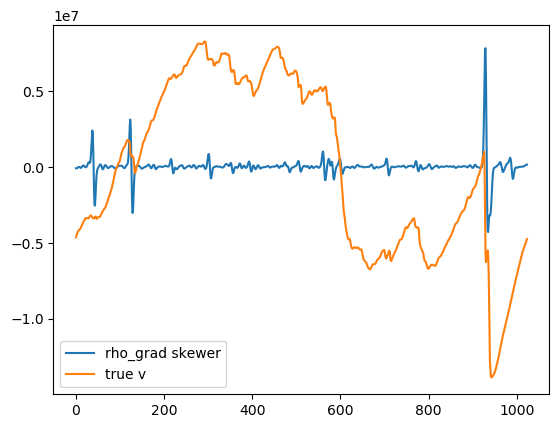

In [254]:
plt.plot(np.asarray(skewer), label="rho_grad skewer")
plt.plot(np.asarray(vel_train[512,:]), label="true v")

#plt.plot(np.asarray(pred_v), label="pred v")

plt.legend()
plt.show()

### Plot fitted vs. original v (2D)

In [203]:
#rho_grad_blurred = tf.squeeze(gaussian_blur(rho_grad, 40, 20))

plt.imshow(rho_grad, vmin=-1, vmax=1)
plt.colorbar()
#plt.show()

In [ ]:
v0, sig_v, a, b = \
    1e7, 10, 1, 0
fitted_v = bary_model_v(v0, sig_v, a, b)
#print(np.min(fitted_v))


# plt.imshow(vel_train)
# plt.title("true v")
# plt.colorbar()
# plt.show()

sig = 10
vel_train = tf.cast(vel_train, 'float64')
blurred_vel = gaussian_blur(vel_train, sig*2, sig)
blurred_vel = tf.squeeze(blurred_vel)
plt.imshow(blurred_vel)
plt.title("blurred v")
plt.colorbar()
plt.show()

#rho_grad = tf.cast(rho_grad, 'float64')
rho_grad_blurred = tf.squeeze(gaussian_blur(rho_grad, 40, 20))

plt.imshow(rho_grad_blurred + 1e-5*np.square(rho_grad_blurred))
plt.title("formula with rho_grad_blurred")
plt.colorbar()
plt.show()

# plt.imshow(fitted_v)
# plt.title("fitted v")
# plt.colorbar()
# plt.show()